# Import libraries, load and transform data

In [1]:
# Install necessary Python packages using pip

# Use the 'pip' command to install packages
# The '-q' flag stands for 'quiet,' which means it will suppress most output, making the installation process less verbose
# We're installing the following packages:
# - 'evaluate': This package is likely used for evaluation purposes, but the specific functionality is not clear from this line alone
# - 'transformers': This package is commonly used for natural language processing tasks, such as working with pre-trained language models like BERT or GPT
# - 'datasets': This package provides easy access to various datasets commonly used in machine learning and natural language processing tasks
# - 'mlflow': MLflow is an open-source platform for managing the end-to-end machine learning lifecycle, including tracking experiments, packaging code into reproducible runs, and sharing and deploying models

# Note: Before running this code, make sure you have Python and pip installed on your system.
# Also, ensure you have an internet connection since pip will download and install these packages from PyPI (Python Package Index).
%pip install -U -q evaluate pandas matplotlib scikit-learn imblearn torchvision transformers tf_keras datasets>=2.14.5 accelerate>=0.27

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2025-04-15 15:25:11.335563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744701911.508262 1959080 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744701911.568709 1959080 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744701911.991766 1959080 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744701911.991802 1959080 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744701911.991804 1959080 computation_placer.cc:177] computation placer alr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Importing necessary libraries and modules
import warnings  # Import the 'warnings' module for handling warnings
warnings.filterwarnings("ignore")  # Ignore warnings during execution
import gc  # Import the 'gc' module for garbage collection
import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import Pandas for data manipulation
import itertools  # Import 'itertools' for iterators and looping
from collections import Counter  # Import 'Counter' for counting elements
import matplotlib.pyplot as plt  # Import Matplotlib for data visualization
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)
# Import custom modules and classes
from imblearn.over_sampling import RandomOverSampler # import RandomOverSampler
import accelerate # Import the 'accelerate' module
import evaluate  # Import the 'evaluate' module
from datasets import Dataset, Image, ClassLabel  # Import custom 'Dataset', 'ClassLabel', and 'Image' classes
from transformers import (  # Import various modules from the Transformers library
    TrainingArguments,  # For training arguments
    Trainer,  # For model training
    ViTImageProcessor,  # For processing image data with ViT models
    ViTForImageClassification,  # ViT model for image classification
    DefaultDataCollator  # For collating data in the default way
)
import torch  # Import PyTorch for deep learning
from torch.utils.data import DataLoader  # For creating data loaders
from torchvision.transforms import (  # Import image transformation functions
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)

In [4]:
# Import the necessary module from the Python Imaging Library (PIL).
from PIL import ImageFile
# Enable the option to load truncated images.
# This setting allows the PIL library to attempt loading images even if they are corrupted or incomplete.
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
# loading the images from DiFF Dataset 
# (loading script) from '~/gscalubayan/aj-code'

# Import necessary libraries
from pathlib import Path
from tqdm import tqdm
import os
# Initialize empty lists to store file names and labels
file_path_column = []  # Holds the file paths of the images
category_column = []  # For fake images: face editing (FE), text to image (T2I), image to image (I2I), or face swapping (FS).
                      # For real images, we will just put 'N/A'
method_column = []  # Holds the methods used for generating fake images, like CoDiff, cycle_diff, imagic, etc.
split_column = []  # Holds the split type: test, train, or val
label_column = []  # 1 for fake images, 0 for real images

In [6]:
from PIL import Image as pilimg

# for filtering
def is_valid_image(path):
    try:
        with pilimg.open(path) as img:
            img.verify()
        return True
    except:
        return False

# Function to add real image data to the columns
def addRealImageToColumns(file, root, DiFF_folder_path, split):
    # Get the absolute path of the image 
    absolute_path = os.path.abspath(os.path.join(root, file))

    # Skip if the path contains '__MACOSX' or filename starts with '._' (metadata)
    if '__MACOSX' in absolute_path or absolute_path.split('/')[-1].startswith('._'):
        return  # Skip this file and do not add it
    
    # if valid image, include in dataset
    if is_valid_image(absolute_path):
        # Append the data to the respective lists
        file_path_column.append(absolute_path)
        category_column.append('N/A')  # Since it's a real image, category is 'N/A'
        method_column.append('N/A')    # No method is used for real images
        split_column.append(split)     # Split is either test, train, or validation
        label_column.append('Real')         # Label is 0 for real images
    return

# Function to process images in each split (train, validation, or test)
def processRealImages(real_folder_path, split, DiFF_folder_path):
    # Determine the real images folder path based on the split
    real_images_path = os.path.join(real_folder_path, split, 'real' if split in ['train', 'val'] else '')
    
    # Check if the folder exists
    if os.path.exists(real_images_path):
        # Traverse through the folder and find all image files
        for root, directories, files in os.walk(real_images_path):
            for file in files:
                # Check if the file is an image by its extension
                if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                    # Add real image data to the columns
                    addRealImageToColumns(file, root, DiFF_folder_path, split)     
        # Check if the images are being added
        # print(f"The length of the file_path column is now {len(file_path_column)} after adding the {split} real images\n")
    else:
        # Print a message if the folder doesn't exist
        print(f"The filepath for the {split} real images does not exist\n")
    return

# Function to get real images from all splits (test, train, and validation)
def getRealImages(DiFF_folder_path):
    # Path to the 'real' images folder within the DiFF dataset
    real_folder_path = os.path.join(DiFF_folder_path, 'real', 'DiFF_real')

    # Process real images for each split (test, train, val)
    for split in ['test', 'train', 'val']:
        processRealImages(real_folder_path, split, DiFF_folder_path)

    return

# Function to add fake image data to the columns
def addFakeImageToColumns(file, root, DiFF_folder_path, method, label, split):
    # Get the absolute path of the image 
    absolute_path = os.path.abspath(os.path.join(root, file))

    # Skip if the path contains '__MACOSX' or filename starts with '._' (metadata)
    if '__MACOSX' in absolute_path or absolute_path.split('/')[-1].startswith('._'):
        return  # Skip this file and do not add it
    
    # if valid image, include in dataset
    if is_valid_image(absolute_path):
        # Append the data to the respective lists
        file_path_column.append(absolute_path)
        category_column.append(label)      # Label refers to category (FE, FS, I2I, T2I)
        method_column.append(method)       # Specific method used to generate the fake image
        split_column.append(split)         # Split type: test, train, or val
        label_column.append('Fake')             # Label is 1 for fake images
    return

# Function to process all images under a specific method folder (e.g., CoDiff, Midjourney)
def getMethodImages(method_folder_path, method, label, split, DiFF_folder_path): 
    # Check if the method folder exists
    if os.path.exists(method_folder_path):
        # Traverse through all directories and image files inside the method folder
        for root, directories, files in os.walk(method_folder_path):
            for file in files:
                # Only process valid image files
                if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                    addFakeImageToColumns(file, root, DiFF_folder_path, method, label, split)
        
        # Log how many files have been added so far 
        # good for debugging right now but we might not need when we add to the OG notebook - gab
        # print(f"The length of the file_path column is now {len(file_path_column)} after adding the {split} {method} {label} fake images\n")
    else:
        print(f"The filepath for the {split} {method} {label} fake images does not exist\n")
    return

# Function to process each category (label) within a split (e.g., FE in train)
def getLabelImages(label_folder_path, label, split, DiFF_folder_path):
    # Based on the category, loop through its associated generation methods
    match label:
        case 'FE':
            for method in ['CoDiff', 'cycle_diff', 'Imagic']:
                method_folder_path = os.path.join(label_folder_path, method)
                getMethodImages(method_folder_path, method, label, split, DiFF_folder_path)
        case 'FS':
            for method in ['DCFace', 'DiffFace']:
                method_folder_path = os.path.join(label_folder_path, method)
                getMethodImages(method_folder_path, method, label, split, DiFF_folder_path)
        case 'I2I':
            for method in ['DreamBooth', 'FreeDoM_I', 'LoRA', 'SDXL_Refine']:
                method_folder_path = os.path.join(label_folder_path, method)
                getMethodImages(method_folder_path, method, label, split, DiFF_folder_path)
        case 'T2I':
            for method in ['FreeDoM_T', 'HPS', 'Midjourney', 'SDXL']:
                method_folder_path = os.path.join(label_folder_path, method)
                getMethodImages(method_folder_path, method, label, split, DiFF_folder_path)
    return

# Function to process all fake image categories (FE, FS, I2I, T2I) within a specific split folder
def processFakeImages(split_folder_path, split, DiFF_folder_path):
    for label in ['FE', 'FS', 'I2I', 'T2I']:
        label_folder_path = os.path.join(split_folder_path, label)
        getLabelImages(label_folder_path, label, split, DiFF_folder_path)
    return

# Function to get fake images from all splits (test, train, and val)
def getFakeImages(DiFF_folder_path):
    # Traverse through test, train, and val split folders
    for split in ['test', 'train', 'val']:
        split_folder_path = os.path.join(DiFF_folder_path, split)
        processFakeImages(split_folder_path, split, DiFF_folder_path)
    return

In [11]:
# Specify the path to the DiFF dataset (this is relative to the location of the Jupyter notebook)
DiFF_folder_path = '/home/gscalubayan/diff-dataset'  # Change this if the location of this file changes 
# changed to absolute filepath -gab

# the file structure of the combined DiFF dataset is as follows
# combined = (the one publicly available) union (the one requested via Google form)

# filepath of (supposedly) saved csv version of this dataframe
csv_save_dir = '/home/gscalubayan/diff-dataset/diff_df.csv'

if not os.path.isfile(csv_save_dir): # if csv has been previously saved already, load that instead (later) to save resources
    # Call the function to populate the columns with real image data
    getRealImages(DiFF_folder_path)
    
    # Call the function to populate the columns with fake image data
    getFakeImages(DiFF_folder_path) 
    
    # Once the columns are populated, we can now create the dataframe from the data
    data = {
        'image': file_path_column,
        'category': category_column,
        'method': method_column,
        'split': split_column,
        'label': label_column
    }
    
    # Create the DataFrame using the data
    df = pd.DataFrame(data)
    print(df.shape)
    df.head()

(597937, 5)


In [10]:
# save csv file and load that instead to save time
if os.path.isfile(csv_save_dir): # if it exists
    df = pd.read_csv(csv_save_dir)
else:
    df.to_csv(csv_save_dir, encoding='utf-8', index=False)

print(df.shape)
df.head()

(597937, 5)


,image,category,method,split,label
0,/home/gscalubayan/diff-dataset/real/DiFF_real/...,NaN,NaN,test,Real
1,/home/gscalubayan/diff-dataset/real/DiFF_real/...,NaN,NaN,test,Real
2,/home/gscalubayan/diff-dataset/real/DiFF_real/...,NaN,NaN,test,Real
3,/home/gscalubayan/diff-dataset/real/DiFF_real/...,NaN,NaN,test,Real
4,/home/gscalubayan/diff-dataset/real/DiFF_real/...,NaN,NaN,test,Real


In [11]:
df['label'].unique()

array(['Real', 'Fake'], dtype=object)

In [12]:
# random oversampling of minority class
# 'y' contains the target variable (label) we want to predict
y = df[['label']]

# Drop the 'label' column from the DataFrame 'df' to separate features from the target variable
df = df.drop(['label'], axis=1)

# Create a RandomOverSampler object with a specified random seed (random_state=83)
ros = RandomOverSampler(random_state=83)

# Use the RandomOverSampler to resample the dataset by oversampling the minority class
# 'df' contains the feature data, and 'y_resampled' will contain the resampled target variable
df, y_resampled = ros.fit_resample(df, y)

# Delete the original 'y' variable to save memory as it's no longer needed
del y

# Add the resampled target variable 'y_resampled' as a new 'label' column in the DataFrame 'df'
df['label'] = y_resampled

# Delete the 'y_resampled' variable to save memory as it's no longer needed
del y_resampled

# Perform garbage collection to free up memory used by discarded variables
gc.collect()

print(df.shape)

(1118740, 5)


In [13]:
# Create a dataset from a Pandas DataFrame.
dataset = Dataset.from_pandas(df).cast_column("image", Image())

Real


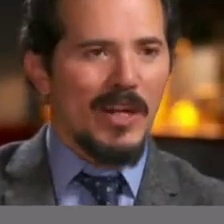

In [14]:
# Display the first image in the dataset
print(dataset[0]["label"])
dataset[0]["image"]

In [17]:
# Extracting a subset of elements from the 'labels' list using slicing.
# The slicing syntax [:5] selects elements from the beginning up to (but not including) the 5th element.
# This will give us the first 5 elements of the 'labels' list.
# The result will be a new list containing these elements.
labels_subset = df['label'][:5].tolist()

# Printing the subset of labels to inspect the content.
print(labels_subset)

['Real', 'Real', 'Real', 'Real', 'Real']


In [18]:
# Creating classlabels to match labels to IDs
labels_list = ['Real', 'Fake'] # list(set(labels))
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# Initialize empty dictionaries to map labels to IDs and vice versa
label2id, id2label = dict(), dict()

# Iterate over the unique labels and assign each label an ID, and vice versa
for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'Real', 1: 'Fake'} 

Mapping of Labels to IDs: {'Real': 0, 'Fake': 1}


In [19]:
# Creating classlabels to match labels to IDs
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# Mapping labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

# Casting label column to ClassLabel Object
dataset = dataset.cast_column('label', ClassLabels)

# Splitting the dataset into training and testing sets using an 60-40 split ratio.
dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")

# Extracting the training data from the split dataset.
train_data = dataset['train']

# Extracting the testing data from the split dataset.
test_data = dataset['test']

Map:   0%|          | 0/1118740 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1118740 [00:00<?, ? examples/s]

In [20]:
# Define the pre-trained ViT model string
model_str = "dima806/deepfake_vs_real_image_detection" # 'google/vit-base-patch16-224-in21k'
# "/home/gscalubayan/csg-aml1-sy2425/huggingface_deepfake_vs_real_image_detection/deepfake_vs_real_image_detection"

# Create a processor for ViT model input from the pre-trained model
processor = ViTImageProcessor.from_pretrained(model_str)

# Retrieve the image mean and standard deviation used for normalization
image_mean, image_std = processor.image_mean, processor.image_std

# Get the size (height) of the ViT model's input images
size = processor.size["height"]
print("Size: ", size)

# Define a normalization transformation for the input images
normalize = Normalize(mean=image_mean, std=image_std)

# Define a set of transformations for training data
_train_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        RandomRotation(90),               # Apply random rotation
        RandomAdjustSharpness(2),         # Adjust sharpness randomly
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

# Define a set of transformations for validation data
_val_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

# Define a function to apply training transformations to a batch of examples
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Define a function to apply validation transformations to a batch of examples
def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

Size:  224


In [21]:
# Set the transforms for the training data
train_data.set_transform(train_transforms)

# Set the transforms for the test/validation data
test_data.set_transform(val_transforms)

In [22]:
# Define a collate function that prepares batched data for model training.
def collate_fn(examples):
    # Stack the pixel values from individual examples into a single tensor.
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    
    # Convert the label strings in examples to corresponding numeric IDs using label2id dictionary.
    labels = torch.tensor([example['label'] for example in examples])
    
    # Return a dictionary containing the batched pixel values and labels.
    return {"pixel_values": pixel_values, "labels": labels}

# Load, train, and evaluate model

In [23]:
# Create a ViTForImageClassification model from a pretrained checkpoint with a specified number of output labels.
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))

# Configure the mapping of class labels to their corresponding indices for later reference.
model.config.id2label = id2label
model.config.label2id = label2id

# Calculate and print the number of trainable parameters in millions for the model.
print(model.num_parameters(only_trainable=True) / 1e6)

85.800194


In [24]:
# Load the accuracy metric from a module named 'evaluate'
accuracy = evaluate.load("accuracy")

# Define a function 'compute_metrics' to calculate evaluation metrics
def compute_metrics(eval_pred):
    # Extract model predictions from the evaluation prediction object
    predictions = eval_pred.predictions
    
    # Extract true labels from the evaluation prediction object
    label_ids = eval_pred.label_ids
    
    # Calculate accuracy using the loaded accuracy metric
    # Convert model predictions to class labels by selecting the class with the highest probability (argmax)
    predicted_labels = predictions.argmax(axis=1)
    
    # Calculate accuracy score by comparing predicted labels to true labels
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']
    
    # Return the computed accuracy as a dictionary with the key "accuracy"
    return {
        "accuracy": acc_score
    }


In [25]:
# Define the name of the evaluation metric to be used during training and evaluation.
metric_name = "accuracy"

# Define the name of the model, which will be used to create a directory for saving model checkpoints and outputs.
model_name = "DiFF_deepfake_vs_real_image_detection"

# Define the number of training epochs for the model.
num_train_epochs = 2

# Create an instance of TrainingArguments to configure training settings.
args = TrainingArguments(
    # Specify the directory where model checkpoints and outputs will be saved.
    output_dir=model_name,
    
    # Specify the directory where training logs will be stored.
    logging_dir='./logs',
    
    # Define the evaluation strategy, which is performed at the end of each epoch.
    eval_strategy="epoch", # from 'evaluation_strategy'
    
    # Set the learning rate for the optimizer.
    learning_rate=1e-6,
    
    # Define the batch size for training on each device.
    per_device_train_batch_size=32,
    
    # Define the batch size for evaluation on each device.
    per_device_eval_batch_size=8,
    
    # Specify the total number of training epochs.
    num_train_epochs=num_train_epochs,
    
    # Apply weight decay to prevent overfitting.
    weight_decay=0.02,
    
    # Set the number of warm-up steps for the learning rate scheduler.
    warmup_steps=50,
    
    # Disable the removal of unused columns from the dataset.
    remove_unused_columns=False,
    
    # Define the strategy for saving model checkpoints (per epoch in this case).
    save_strategy='epoch',
    
    # Load the best model at the end of training.
    load_best_model_at_end=True,
    
    # Limit the total number of saved checkpoints to save space.
    save_total_limit=1,
    
    # Specify that training progress should not be reported.
    report_to="none",
    
    # Enable mixed precision for speedup
    fp16=True,  
    
    # Optimize data loading
    dataloader_num_workers=4
)

In [26]:
# Create a Trainer instance for fine-tuning a language model.

# - `model`: The pre-trained language model to be fine-tuned.
# - `args`: Configuration settings and hyperparameters for training.
# - `train_dataset`: The dataset used for training the model.
# - `eval_dataset`: The dataset used for evaluating the model during training.
# - `data_collator`: A function that defines how data batches are collated and processed.
# - `compute_metrics`: A function for computing custom evaluation metrics.
# - `tokenizer`: The tokenizer used for processing text data.

trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [27]:
# Evaluate the pre-training model's performance on a test dataset.
# This function calculates various metrics such as accuracy, loss, etc.,
# to assess how well the model is performing on unseen data.

trainer.evaluate()

{'eval_loss': 2.3509278297424316,
 'eval_model_preparation_time': 0.0019,
 'eval_accuracy': 0.45737392066074334,
 'eval_runtime': 693.1699,
 'eval_samples_per_second': 645.579,
 'eval_steps_per_second': 80.697}

In [28]:
# Start training the model using the trainer object.
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,0.055500,0.091548,0.001900,0.967799
2,0.038700,0.061134,0.001900,0.979676


TrainOutput(global_step=41954, training_loss=0.078352304684023, metrics={'train_runtime': 3579.1224, 'train_samples_per_second': 375.089, 'train_steps_per_second': 11.722, 'total_flos': 1.0403206615371438e+20, 'train_loss': 0.078352304684023, 'epoch': 2.0})

In [30]:
# Evaluate the post-training model's performance on the validation or test dataset.
# This function computes various evaluation metrics like accuracy, loss, etc.
# and provides insights into how well the model is performing.

trainer.evaluate()

{'eval_loss': 0.06113439425826073,
 'eval_model_preparation_time': 0.0019,
 'eval_accuracy': 0.9796757959847686,
 'eval_runtime': 652.667,
 'eval_samples_per_second': 685.642,
 'eval_steps_per_second': 85.705,
 'epoch': 2.0}

In [31]:
# Use the trained 'trainer' to make predictions on the 'test_data'.
outputs = trainer.predict(test_data)

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

{'test_loss': 0.06113439425826073, 'test_model_preparation_time': 0.0019, 'test_accuracy': 0.9796757959847686, 'test_runtime': 658.9137, 'test_samples_per_second': 679.142, 'test_steps_per_second': 84.893}


Accuracy: 0.9797
F1 Score: 0.9797


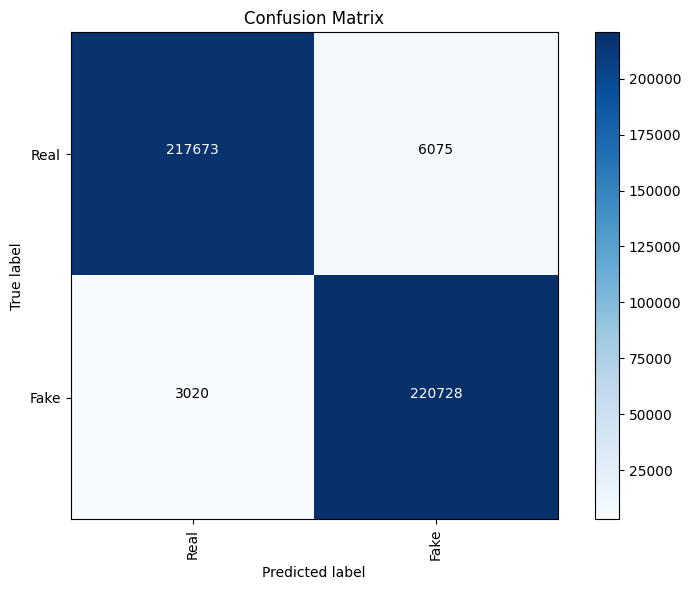


Classification report:

              precision    recall  f1-score   support

        Real     0.9863    0.9728    0.9795    223748
        Fake     0.9732    0.9865    0.9798    223748

    accuracy                         0.9797    447496
   macro avg     0.9798    0.9797    0.9797    447496
weighted avg     0.9798    0.9797    0.9797    447496



In [32]:
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)
    
    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a small number of labels
if len(labels_list) <= 150:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))
    
# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

In [29]:
# Save the trained model: This line of code is responsible for saving the model
# that has been trained using the trainer object. It will serialize the model
# and its associated weights, making it possible to reload and use the model
# in the future without the need to retrain it.
trainer.save_model()

In [33]:
# Import the 'pipeline' function from the 'transformers' library.
from transformers import pipeline

# Create a pipeline for image classification tasks. 
# You need to specify the 'model_name' and the 'device' to use for inference.
# - 'model_name': The name of the pre-trained model to be used for image classification.
# - 'device': Specifies the device to use for running the model (0 for GPU, -1 for CPU).
pipe = pipeline('image-classification', model=model_name, device=0)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


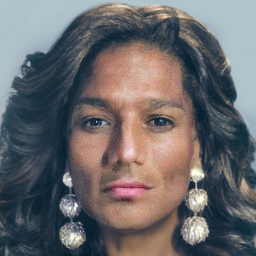

In [34]:
# Accessing an image from the 'test_data' dataset using index 1.
image = test_data[1]["image"]

# Displaying the 'image' variable.
image

In [35]:
# Apply the 'pipe' function to process the 'image' variable.
pipe(image)

[{'label': 'Fake', 'score': 0.9798086285591125},
 {'label': 'Real', 'score': 0.020191319286823273}]

In [36]:
# This line of code accesses the "label" attribute of a specific element in the test_data list.
# It's used to retrieve the actual label associated with a test data point.
id2label[test_data[1]["label"]]

'Fake'